In [1]:
# Copyright (C) 2017 Zhixian MA <zxma_sjtu@qq.com>

# Do MNIST feature learning by our code agn-ae

In [2]:
import numpy as np
import matplotlib
matplotlib.use('Agg') # Change matplotlib backend, in case we have no X server running..
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image as IPImage
from PIL import Image

import sys   
sys.setrecursionlimit(1000000)

In [3]:
from ConvAE import ConvAE
import utils

Using gpu device 0: GeForce 940MX (CNMeM is disabled, cuDNN 5105)


In [4]:
# load data
import pickle
fname = 'mnist/mnist.pkl'
fp = open(fname, 'rb')
train,valid,test = pickle.load(fp,encoding='latin1')
fp.close()

In [5]:
X_train, y_train = train
X_test, y_test = test
# randomly select 10000 samples

print('X_train type and shape:', X_train.dtype, X_train.shape)
print('X_train.min():', X_train.min())
print('X_train.max():', X_train.max())

print('X_test type and shape:', X_test.dtype, X_test.shape)
print('X_test.min():', X_test.min())
print('X_test.max():', X_test.max())

X_train type and shape: float32 (50000, 784)
X_train.min(): 0.0
X_train.max(): 0.996094
X_test type and shape: float32 (10000, 784)
X_test.min(): 0.0
X_test.max(): 0.996094


In [6]:
# define the net
idx = np.random.permutation(X_train.shape[0])
X = X_train[idx[0:10000],:]
X_in = X.reshape(-1,1,28,28)
X_out = X
kernel_size = [3, 3, 3]
kernel_num = [16, 16, 32]
pool_flag = [False, True, True]
fc_nodes = [128]
encode_nodes = 16
net = ConvAE(X_in=X_in, X_out=X_out, kernel_size=kernel_size, pool_flag=pool_flag,
             kernel_num=kernel_num, fc_nodes=fc_nodes, encode_nodes = 16)

In [7]:
# generate layers
net.gen_layers()
net.layers

[(lasagne.layers.input.InputLayer, {'shape': (None, 1, 28, 28)}),
 (lasagne.layers.conv.Conv2DLayer,
  {'filter_size': 3, 'num_filters': 16, 'pad': 'valid'}),
 (lasagne.layers.conv.Conv2DLayer,
  {'filter_size': 3, 'num_filters': 16, 'pad': 'valid'}),
 (lasagne.layers.pool.MaxPool2DLayer, {'pool_size': 2}),
 (lasagne.layers.conv.Conv2DLayer,
  {'filter_size': 3, 'num_filters': 32, 'pad': 'valid'}),
 (lasagne.layers.pool.MaxPool2DLayer, {'pool_size': 2}),
 (lasagne.layers.shape.ReshapeLayer, {'shape': ([0], -1)}),
 (lasagne.layers.dense.DenseLayer, {'num_units': 128}),
 (lasagne.layers.dense.DenseLayer, {'name': 'encode', 'num_units': 16}),
 (lasagne.layers.dense.DenseLayer, {'num_units': 128}),
 (lasagne.layers.dense.DenseLayer, {'num_units': 800}),
 (lasagne.layers.shape.ReshapeLayer, {'shape': ([0], 32, 5, 5)}),
 (lasagne.layers.pool.Upscale2DLayer, {'scale_factor': 2}),
 (lasagne.layers.conv.Conv2DLayer,
  {'filter_size': 3, 'num_filters': 32, 'pad': 'full'}),
 (lasagne.layers.pool.

In [8]:
# Build the network and initilization
net.cae_build(learning_rate=0.01, momentum=0.975)

In [9]:
# Train the network
net.cae_train()

Training the network...
# Neural Network with 231105 learnable parameters

## Layer information

  #  name         size
---  -----------  --------
  0  input0       1x28x28
  1  conv2d1      16x26x26
  2  conv2d2      16x24x24
  3  maxpool2d3   16x12x12
  4  conv2d4      32x10x10
  5  maxpool2d5   32x5x5
  6  reshape6     800
  7  dense7       128
  8  encode       16
  9  dense9       128
 10  dense10      800
 11  reshape11    32x5x5
 12  upscale2d12  32x10x10
 13  conv2d13     32x12x12
 14  upscale2d14  32x24x24
 15  conv2d15     16x26x26
 16  conv2d16     1x28x28
 17  reshape17    784

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.09668     0.09061    1.06702  6.73s
      2     0.07771     0.06701    1.15961  6.03s
      3     0.06397     0.06206    1.03079  5.68s
      4     0.05927     0.05703    1.03930  5.67s
      5     0.05405     0.05190    1.04138  5.68s
      6     0.04894     0.04689    1.04384  5.67s
     

In [10]:
# save result
net.cae_save('mnist/net.pkl')

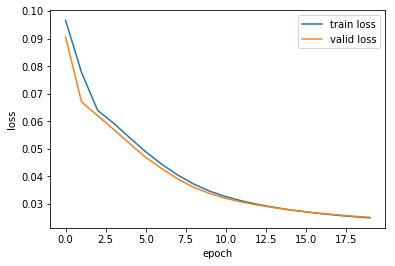

In [11]:
# Plot the loss curve
net.cae_eval()

In [12]:
# from imp import reload
# reload(utils)
# Test the network
imgs = X_test.reshape(-1,28,28)
img_small = imgs[30,:,:]
'''
# encode
img_en = utils.get_encode(net.cae, img_small)
# decode
img_de = utils.get_decode(net.cae, img_en)

# Compare
img_pre = np.rint(img_de.reshape(28,28) * 256).astype(int)
img_pre = np.clip(img_pre, a_min = 0, a_max = 255)
img_pre = img_pre.astype('uint8')
plt.imshow(img_pre)
'''

img_pre = utils.get_predict(net.cae, img_small)

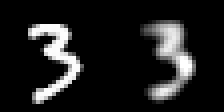

In [13]:
def get_picture_array(X, rescale=4):
    array = X.reshape(28,28)
    array = np.clip(array, a_min = 0, a_max = 255)
    return  array.repeat(rescale, axis = 0).repeat(rescale, axis = 1).astype(np.uint8())

def compare_images(img, img_pre):
    original_image = Image.fromarray(get_picture_array(255 * img))
    new_size = (original_image.size[0] * 2, original_image.size[1])
    new_im = Image.new('L', new_size)
    new_im.paste(original_image, (0,0))
    rec_image = Image.fromarray(get_picture_array(img_pre))
    new_im.paste(rec_image, (original_image.size[0],0))
    new_im.save('mnist/test.png', format="PNG")
    return IPImage('mnist/test.png')

compare_images(img_small, img_pre)

Concating the maps


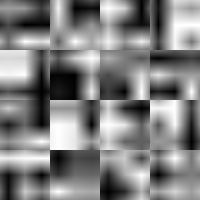

In [14]:
# The feature maps
# c1
utils.get_concate(net.cae,1,'mnist/Conv1')
IPImage('mnist/Conv1/map_con.png')

Concating the maps


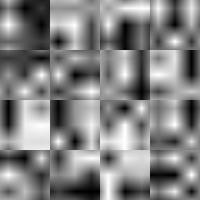

In [18]:
# c2
utils.get_concate(net.cae,2,'mnist/Conv2')
IPImage('mnist/Conv2/map_con.png')

Concating the maps


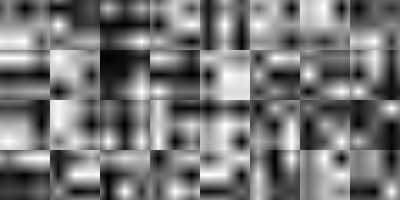

In [19]:
# c3
utils.get_concate(net.cae,4,'mnist/Conv3',perline=8)
IPImage('mnist/Conv3/map_con.png')